#### Inputs:
###### patient details
1. Age
2. Weight
3. Gender
4. Existing Medical Condition
###### other sensors
5. Heart Rate
6. ETCO2
7. SpO2
###### ventilator prototype
8. Expired CO2
9. Expire O2
10. MVe
11. Frequency
12. Humidity
13. Volume per movement
###### feedback loop
14. Inspiration to Expiration Rate
15. FiO2
16. Tidal Volume
17. PEEP

#### Outputs:
1. Pressure Value (PEEP)
2. Tidal Volume
3. O2 level
4. Inpiration to Expiration Rate
5. Ventilator Pressure
6. FiO2

In [1]:
import numpy as np
import pandas as pd
import json
import csv
import matplotlib.pyplot as plt

from pickle import dump

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

seed = 1234

In [35]:
with open('data.json') as vent_data:
    records = json.load(vent_data)

In [37]:
records[0]['0']

{'device_id': 4242,
 'processed': {'ExpiredCO2': 4.78,
  'ExpiredO2': 40.32,
  'FiO2': 20.4,
  'IE': 1.3,
  'MVe': 6345,
  'PEEP': 0,
  'RR': 15,
  'VT': 400,
  'flowrate': -4532,
  'frequency': 10,
  'humidity': 70.5,
  'pressure': 1,
  'triggerSettings': {'FiO2': 20,
   'IE': 1.3,
   'MVe': 6000,
   'PEEP': 0,
   'RR': 15,
   'VT': 400,
   'humidity': 70,
   'pressure_max': 10},
  'ventilationMode': 'Flowrate Control',
  'volumePerMinute': 2200,
  'volumePerMovement': 220},
 'raw': {'CO2': 4.78,
  'O2': 40.32,
  'angleSensor': 320,
  'current': 50,
  'motorRPM': 100,
  'pressure1': 48,
  'pressure2': 109,
  'temperature1': 30.08,
  'temperature2': 32.71},
 'time': 1587238538}

In [34]:
[{"Device_id":key,
  "TimeStamp":value['time'],
  **value['processed']['triggerSettings'], 
  **value['raw'], 
  **value['processed'].pop('triggerSettings', None)
 } 
 for key, value in records[0].items()]


[{'Device_id': '0',
  'TimeStamp': 1587238538,
  'FiO2': 20,
  'IE': 1.3,
  'MVe': 6000,
  'PEEP': 0,
  'RR': 15,
  'VT': 400,
  'humidity': 70,
  'pressure_max': 10,
  'CO2': 4.78,
  'O2': 40.32,
  'angleSensor': 320,
  'current': 50,
  'motorRPM': 100,
  'pressure1': 48,
  'pressure2': 109,
  'temperature1': 30.08,
  'temperature2': 32.71},
 {'Device_id': '1',
  'TimeStamp': 1587238538,
  'FiO2': 20,
  'IE': 1.3,
  'MVe': 6000,
  'PEEP': 0,
  'RR': 15,
  'VT': 400,
  'humidity': 70,
  'pressure_max': 10,
  'CO2': 4.85,
  'O2': 40.65,
  'angleSensor': 320,
  'current': 50,
  'motorRPM': 100,
  'pressure1': 43,
  'pressure2': 86,
  'temperature1': 30.84,
  'temperature2': 27.68},
 {'Device_id': '2',
  'TimeStamp': 1587238538,
  'FiO2': 20,
  'IE': 1.3,
  'MVe': 6000,
  'PEEP': 0,
  'RR': 15,
  'VT': 400,
  'humidity': 70,
  'pressure_max': 10,
  'CO2': 4.76,
  'O2': 37.79,
  'angleSensor': 320,
  'current': 50,
  'motorRPM': 100,
  'pressure1': 45,
  'pressure2': 94,
  'temperature1': 

In [22]:
records[0].

SyntaxError: invalid syntax (<ipython-input-22-2bbf22511acc>, line 1)

In [1]:
# list of all keys in json file
# print(data.keys(), data['0'].keys(), data['0']['processed'].keys(), data['0']['processed']['triggerSettings'].keys())

In [ ]:
df = pd.DataFrame()
for j in range(len(records)):
    data = records[j]
    for i in range(5):
        a = pd.Series(data[str(i)]['device_id'], name='Device_id')
        b = pd.Series(data[str(i)]['time'], name='TimeStamp')
        c = pd.DataFrame(data[str(i)]['processed'], index=[0]).drop(columns='triggerSettings')
        d = pd.DataFrame(data[str(i)]['processed']['triggerSettings'], index=[0])
        e = pd.DataFrame(data[str(i)]['raw'], index=[0])
        # pd.concat([a, b, c, d, e], axis=1)
        df = pd.concat([df, pd.concat([a, b, c, d, e], axis=1)])
df.to_csv('json_to_dataframe.csv')    

In [ ]:
df.sort_values(['Device_id', 'TimeStamp'])

In [ ]:
device_list = []
for device in df.Device_id.unique():
    device_list.append(device)
device_list

In [55]:
with open('foo.csv', 'w', newline='') as f:
     df[df['Device_id'] == 4242].describe().to_csv(f)
for device in device_list[::-1]:
    with open('foo.csv', 'a', newline='') as f:
        df[df['Device_id'] == device].describe().to_csv(f, header=False)

In [45]:
#drop_columns = ['TimeStamp', 'CO2','O2', 'angleSensor', 'current', 'pressure1', 'pressure2', 'ventilationMode']
df = df.drop(labels='ventilationMode', axis=1)

In [46]:
df.head()

,Device_id,ExpiredCO2,ExpiredO2,MVe,flowrate,frequency,pressure,volumePerMinute,volumePerMovement,FiO2,...,pressure_max,CO2,O2,angleSensor,current,motorRPM,pressure1,pressure2,temperature1,temperature2
TimeStamp,,,,,,,,,,,,,,,,,,,,,
1587197548,93,4.68,37.92,4500,5000,10,5,2200,220,60,...,40,4.68,37.92,320,50,100,35,36,24.38,27.55
1587197758,93,4.84,41.86,4500,5000,10,5,2200,220,60,...,40,4.84,41.86,320,50,100,35,36,23.86,26.38
1587197759,93,4.88,41.87,4500,5000,10,5,2200,220,60,...,40,4.88,41.87,320,50,100,35,36,23.84,26.14
1587197760,93,4.81,41.13,4500,5000,10,5,2200,220,60,...,40,4.81,41.13,320,50,100,35,36,23.87,26.08
1587197761,93,4.80,40.85,4500,5000,10,5,2200,220,60,...,40,4.80,40.85,320,50,100,35,36,23.92,26.11


In [49]:
df = df.astype('float32')

#### data pre-processing

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22454 entries, 1587197548 to 1587202259
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Device_id          22454 non-null  float32
 1   ExpiredCO2         22454 non-null  float32
 2   ExpiredO2          22454 non-null  float32
 3   MVe                22454 non-null  float32
 4   flowrate           22454 non-null  float32
 5   frequency          22454 non-null  float32
 6   pressure           22454 non-null  float32
 7   volumePerMinute    22454 non-null  float32
 8   volumePerMovement  22454 non-null  float32
 9   FiO2               22454 non-null  float32
 10  IE                 22454 non-null  float32
 11  MVe                22454 non-null  float32
 12  PEEP               22454 non-null  float32
 13  RR                 22454 non-null  float32
 14  VT                 22454 non-null  float32
 15  humidity           22454 non-null  float32
 16  pressure

In [51]:
#df = df.sort_values(['Device_id', 'TimeStamp'])
#df = df.set_index('TimeStamp')

# generate target values
df2 = df.copy()
df2['Target_VT'] = df2.groupby(['Device_id'])['VT'].shift(30)
df2['Target_PEEP'] = df2.groupby(['Device_id'])['PEEP'].shift(30)
df2['Target_FiO2'] = df2.groupby(['Device_id'])['FiO2'].shift(30)
df2['Target_IE'] = df2.groupby(['Device_id'])['IE'].shift(30)

In [52]:
df2.head()

,Device_id,ExpiredCO2,ExpiredO2,MVe,flowrate,frequency,pressure,volumePerMinute,volumePerMovement,FiO2,...,current,motorRPM,pressure1,pressure2,temperature1,temperature2,Target_VT,Target_PEEP,Target_FiO2,Target_IE
TimeStamp,,,,,,,,,,,,,,,,,,,,,
1587197548,93.0,4.68,37.919998,4500.0,5000.0,10.0,5.0,2200.0,220.0,60.0,...,50.0,100.0,35.0,36.0,24.379999,27.549999,NaN,NaN,NaN,NaN
1587197758,93.0,4.84,41.860001,4500.0,5000.0,10.0,5.0,2200.0,220.0,60.0,...,50.0,100.0,35.0,36.0,23.860001,26.379999,NaN,NaN,NaN,NaN
1587197759,93.0,4.88,41.869999,4500.0,5000.0,10.0,5.0,2200.0,220.0,60.0,...,50.0,100.0,35.0,36.0,23.840000,26.139999,NaN,NaN,NaN,NaN
1587197760,93.0,4.81,41.130001,4500.0,5000.0,10.0,5.0,2200.0,220.0,60.0,...,50.0,100.0,35.0,36.0,23.870001,26.080000,NaN,NaN,NaN,NaN
1587197761,93.0,4.80,40.849998,4500.0,5000.0,10.0,5.0,2200.0,220.0,60.0,...,50.0,100.0,35.0,36.0,23.920000,26.110001,NaN,NaN,NaN,NaN


In [53]:
df2.to_csv('target_value.csv')

In [54]:
df2.dropna(subset = ["Target_IE"], inplace=True)

In [55]:
df2.head()

,Device_id,ExpiredCO2,ExpiredO2,MVe,flowrate,frequency,pressure,volumePerMinute,volumePerMovement,FiO2,...,current,motorRPM,pressure1,pressure2,temperature1,temperature2,Target_VT,Target_PEEP,Target_FiO2,Target_IE
TimeStamp,,,,,,,,,,,,,,,,,,,,,
1587197787,93.0,5.04,41.770000,4500.0,5000.0,10.0,5.0,2200.0,220.0,60.0,...,50.0,100.0,35.0,36.0,24.400000,27.629999,325.0,6.1,60.0,1.4
1587197788,93.0,5.12,42.209999,4500.0,5000.0,10.0,5.0,2200.0,220.0,60.0,...,50.0,100.0,35.0,36.0,24.320000,27.469999,325.0,6.1,60.0,1.4
1587197789,93.0,5.17,42.330002,4500.0,5000.0,10.0,5.0,2200.0,220.0,60.0,...,50.0,100.0,35.0,36.0,24.080000,27.309999,325.0,6.1,60.0,1.4
1587197790,93.0,5.17,42.189999,4500.0,5000.0,10.0,5.0,2200.0,220.0,60.0,...,50.0,100.0,35.0,36.0,24.150000,27.180000,325.0,6.1,60.0,1.4
1587197791,93.0,5.18,41.459999,4500.0,5000.0,10.0,5.0,2200.0,220.0,60.0,...,50.0,100.0,35.0,36.0,24.299999,27.430000,325.0,6.1,60.0,1.4


In [ ]:
ct = ColumnTransformer(transformers=[('one_hot_encoder',
                                      OneHotEncoder(categories='auto'),
                                      [0])],
                       remainder='passthrough')

data_array = ct.fit_transform(df2)

In [92]:
data_array.shape

(22304, 34)

In [66]:
X = data_array[:, :-4]
y = data_array[:, -4:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=1,
                                                    shuffle=True)

In [127]:
np.savetxt("array.csv", data_array, delimiter=",")

In [101]:
#not used as data is fully bias
#fio2_scaler = MinMaxScaler(feature_range=(0.3, 1))
#vt_scaler = MinMaxScaler(feature_range=(200, 1200))
#ie_scaler = MinMaxScaler(feature_range=(0.25, 0.5))
#peep_scaler = MinMaxScaler(feature_range=(5, 20))

# general min max scaler used
scaler = MinMaxScaler()
scaler2 = MinMaxScaler()

In [102]:
X_train[:, 5:] = scaler.fit_transform(X_train[:, 5:])
X_test[:, 5:] = scaler.transform(X_test[:, 5:])
y_train[:, -4:] = scaler2.fit_transform(y_train[:, -4:])
y_test[:, -4:] = scaler2.transform(y_test[:, -4:])

In [128]:
np.savetxt("array2.csv", X_train, delimiter=",")

In [96]:
X_train.shape[1], y.shape[1]

(30, 4)

In [124]:
def create_ann():
    model = Sequential()
    model.add(Dense(units=512,  # number of neurons
                    activation='relu',  # activation function
                    kernel_initializer=glorot_uniform(seed),  # weight initialization
                    input_dim=X_train.shape[1],  # number of features
                    name='layer_1'))
    model.add(Dropout(rate=0.2))  # removing weights to improve performance

    model.add(Dense(units=512,
                    activation='relu',
                    kernel_initializer=glorot_uniform(seed),
                    name='layer_2'))
    model.add(Dropout(rate=0.3))

    model.add(Dense(units=128,
                    activation='relu',
                    kernel_initializer=glorot_uniform(seed),
                    name='layer_3'))
    model.add(Dropout(rate=0.2))
    
    model.add(Dense(units=y.shape[1], activation='sigmoid',
                    name='output_layer'))

    model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model


network = create_ann()
es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
# training the model
history = network.fit(x=X_train, y=y_train,
                      validation_split=0.2,
                      batch_size=128,
                      callbacks=[es],
                      epochs=300,
                      verbose=1)

# Save Model
network.save('ann_model.h5')

Train on 14273 samples, validate on 3569 samples
Epoch 1/300
14273/14273 [==============================] - 1s 85us/sample - loss: 0.2334 - accuracy: 0.9785 - val_loss: 0.0083 - val_accuracy: 1.0000
Epoch 2/300
14273/14273 [==============================] - 1s 47us/sample - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 3/300
14273/14273 [==============================] - 1s 53us/sample - loss: 9.4942e-04 - accuracy: 1.0000 - val_loss: 3.6054e-04 - val_accuracy: 1.0000
Epoch 4/300
14273/14273 [==============================] - 1s 48us/sample - loss: 3.9744e-04 - accuracy: 1.0000 - val_loss: 1.5598e-04 - val_accuracy: 1.0000
Epoch 5/300
14273/14273 [==============================] - 1s 51us/sample - loss: 2.0432e-04 - accuracy: 1.0000 - val_loss: 7.8351e-05 - val_accuracy: 1.0000
Epoch 6/300
14273/14273 [==============================] - 1s 51us/sample - loss: 1.1365e-04 - accuracy: 1.0000 - val_loss: 4.2871e-05 - val_accuracy: 1.0000
Epoch 7/300
14273/1

14273/14273 [==============================] - 1s 49us/sample - loss: 2.3410e-08 - accuracy: 1.0000 - val_loss: 2.3183e-10 - val_accuracy: 1.0000
Epoch 104/300
14273/14273 [==============================] - 1s 49us/sample - loss: 1.5994e-08 - accuracy: 1.0000 - val_loss: 2.1981e-10 - val_accuracy: 1.0000
Epoch 105/300
14273/14273 [==============================] - 1s 54us/sample - loss: 2.0890e-08 - accuracy: 1.0000 - val_loss: 2.0553e-10 - val_accuracy: 1.0000
Epoch 106/300
14273/14273 [==============================] - 1s 50us/sample - loss: 1.5373e-08 - accuracy: 1.0000 - val_loss: 1.9460e-10 - val_accuracy: 1.0000
Epoch 107/300
14273/14273 [==============================] - 1s 46us/sample - loss: 2.1023e-08 - accuracy: 1.0000 - val_loss: 1.8105e-10 - val_accuracy: 1.0000
Epoch 108/300
14273/14273 [==============================] - 1s 47us/sample - loss: 2.4476e-08 - accuracy: 1.0000 - val_loss: 1.6749e-10 - val_accuracy: 1.0000
Epoch 109/300
14273/14273 [===========================

14273/14273 [==============================] - 1s 46us/sample - loss: 5.6815e-10 - accuracy: 1.0000 - val_loss: 2.2963e-12 - val_accuracy: 1.0000
Epoch 206/300
14273/14273 [==============================] - 1s 46us/sample - loss: 8.1351e-10 - accuracy: 1.0000 - val_loss: 2.2269e-12 - val_accuracy: 1.0000
Epoch 207/300
14273/14273 [==============================] - 1s 44us/sample - loss: 1.1524e-09 - accuracy: 1.0000 - val_loss: 2.1395e-12 - val_accuracy: 1.0000
Epoch 208/300
14273/14273 [==============================] - 1s 46us/sample - loss: 8.3639e-10 - accuracy: 1.0000 - val_loss: 2.0877e-12 - val_accuracy: 1.0000
Epoch 209/300
14273/14273 [==============================] - 1s 45us/sample - loss: 4.4570e-10 - accuracy: 1.0000 - val_loss: 2.0406e-12 - val_accuracy: 1.0000
Epoch 210/300
14273/14273 [==============================] - 1s 45us/sample - loss: 7.3863e-10 - accuracy: 1.0000 - val_loss: 1.9833e-12 - val_accuracy: 1.0000
Epoch 211/300
14273/14273 [===========================

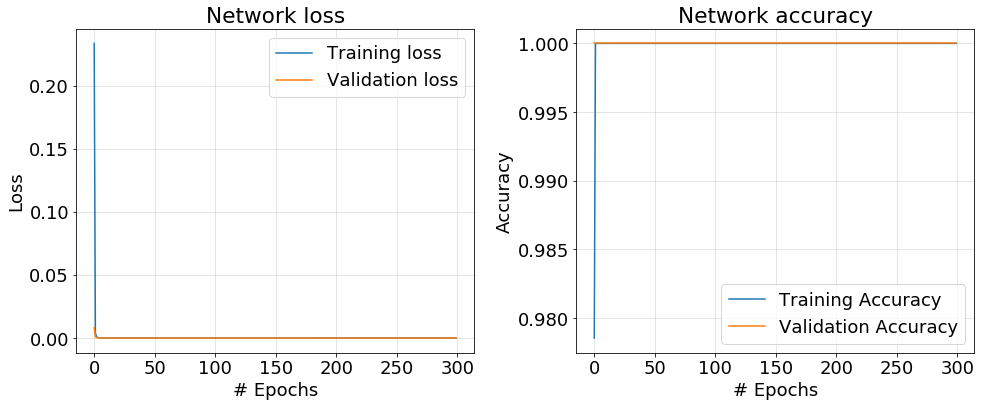

In [125]:
def get_model_param_plot():
    fig = plt.figure(figsize=(14, 6))
    plt.rcParams.update({'font.size': '18'})
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Network loss')
    plt.xlabel('# Epochs')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.4)
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Network accuracy')
    plt.xlabel('# Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True, alpha=0.4)
    plt.legend(loc='best')

    fig.tight_layout()
    fig.savefig('model_parameters.jpg', bbox_inches='tight',
                dpi=150, facecolor='grey', edgecolor='black')


get_model_param_plot()

In [120]:
y_pred = network.predict(X_test[-1].reshape(1, -1))
y_pred

array([[4.842121e-18, 5.995301e-18, 5.785387e-18, 8.601938e-18]],
      dtype=float32)

In [123]:
scaler2.inverse_transform(y_pred.reshape(1, -1))

array([[4.842121e-18, 5.995301e-18, 5.785387e-18, 8.601938e-18]],
      dtype=float32)

fio2, ie, peep, vt = 8, 9, 11, 12

X_train[:, fio2] = fio2_scaler.fit_transform(X_train[:, fio2])
X_train[:, ie] = ie_scaler.fit_transform(X_train[:, ie])
X_train[:, vt] = vt_scaler.fit_transform(X_train[:, vt])
X_train[:, peep] = peep_scaler.fit_transform(X_train[:, peep])
X_train[:, col] = scaler.fit_transform(X_train[:, col])

X_test[:, fio2] = fio2_scaler.fit_transform(X_test[:, fio2])
X_test[:, ie] = ie_scaler.fit_transform(X_test[:, ie])
X_test[:, vt] = vt_scaler.fit_transform(X_test[:, vt])
X_test[:, peep] = peep_scaler.fit_transform(X_test[:, peep])
X_test[:, col] = scaler.fit_transform(X_test[:, col])

n = 1000
d = 93
fig = plt.figure(figsize=(20, 12))
plt.rcParams.update({'font.size': 14})
plt.subplot(2, 1, 1)
plt.plot(np.arange(0, len(df[df['Device_id'] == d]['ExpiredCO2'].iloc[:n]), 1),
         df[df['Device_id'] == d]['ExpiredCO2'].iloc[:n])
plt.xlabel('timestep')
plt.ylabel('Expired CO2')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(np.arange(0, len(df[df['Device_id'] == d]['ExpiredO2'].iloc[:n]), 1),
         df[df['Device_id'] == d]['ExpiredO2'].iloc[:n])
plt.xlabel('timestep')
plt.ylabel('Expired O2')
plt.grid(True)

plt.savefig('Expired Air_93.jpg')